In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as seabornInstance
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')
# TIMES SERIES LIBRARIES
from sklearn.metrics import classification_report

In [2]:
#Reading the dataset
dataset = pd.read_excel('DATASET_W.xlsx')

In [3]:
# displaying the first 10 rows in the DataFrame
dataset.head()


,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE
0,81243,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0
1,81243,2023-03-03,LUNCH,INCLUDED,MAIN_SIDES,NaN,NaN,0.0
2,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0
3,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0
4,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0


In [4]:
dataset.columns

Index(['ORDER_ID', 'DATE', 'TIME', 'MENU_ITEM', 'MENU_CATEGORY', 'TEMP',
       'SAUCE', 'MENU_PRICE'],
      dtype='object')

In [5]:
# displaying rows x columns.
dataset.shape

(2084, 8)

In [6]:
# showing the summary statistics of our numerical columns
dataset.describe()

,ORDER_ID,MENU_PRICE
count,2084.000000,2084.000000
mean,186381.268714,21.840691
std,252947.112428,24.516756
min,101.000000,0.000000
25%,462.000000,0.000000
50%,98294.000000,10.000000
75%,191364.750000,44.000000
max,948474.000000,98.000000


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ORDER_ID       2084 non-null   int64         
 1   DATE           2084 non-null   datetime64[ns]
 2   TIME           2084 non-null   object        
 3   MENU_ITEM      2084 non-null   object        
 4   MENU_CATEGORY  2084 non-null   object        
 5   TEMP           937 non-null    object        
 6   SAUCE          936 non-null    object        
 7   MENU_PRICE     2084 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 130.4+ KB


<AxesSubplot:>

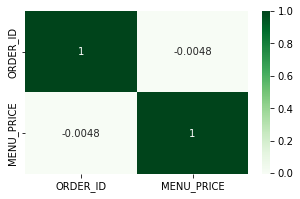

In [8]:
plt.figure(figsize=(5,3))
sns.heatmap(dataset.corr(),annot=True, cmap="Greens")

In [9]:
# Grouping by ORDER_ID and count the number of MENU_ITEM in each group
menu_counts = dataset.groupby('ORDER_ID')['MENU_ITEM'].count()

# Grouping by ORDER_ID and sum the MENU_PRICE in each group
menu_prices = dataset.groupby('ORDER_ID')['MENU_PRICE'].sum()

# Combine the two Series into a single DataFrame
result = pd.concat([menu_counts, menu_prices], axis=1)

# Print the result
result.head(100)

,MENU_ITEM,MENU_PRICE
ORDER_ID,,
101,1,47.0
102,1,24.0
103,3,69.0
104,4,117.0
105,2,53.0
...,...,...
222,2,6.0
223,2,44.0
224,1,5.0


### Finding out how many orders we have

In [10]:
pd.DataFrame([{'Items': len(dataset['MENU_ITEM'].value_counts()),    
               'Order': len(dataset['ORDER_ID'].value_counts()),
                 }], columns = ['Items', 'Order'], index = ['ORDER_ID'])

,Items,Order
ORDER_ID,46,627


We can Observe a total of 627 ordres along with 46 unique item oredered. 

In [11]:

dataset['DAY_OF_WEEK'] = dataset['DATE'].dt.day_name()

In [12]:
dataset.head(100)

,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK
0,81243,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday
1,81243,2023-03-03,LUNCH,INCLUDED,MAIN_SIDES,NaN,NaN,0.0,Friday
2,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday
3,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday
4,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday
...,...,...,...,...,...,...,...,...,...
95,99297,2023-03-03,DINNER,GREEN BEANS,EXTRA_SIDE,NaN,NaN,6.0,Friday
96,99297,2023-03-03,DINNER,BROCCOLI,EXTRA_SIDE,NaN,NaN,7.0,Friday
97,99297,2023-03-03,DINNER,SPINACH,EXTRA_SIDE,NaN,NaN,6.0,Friday
98,99297,2023-03-03,DINNER,ONION RINGS,EXTRA_SIDE,NaN,NaN,7.0,Friday


In [13]:
# Criar a coluna 'day_type' com base na coluna 'day_of_week'
dataset['DAY_TYPE'] = dataset['DAY_OF_WEEK'].apply(
    lambda x: 'WEEKDAY' if x in ['Monday', 'Tuesday', 'Wednesday', 
    'Thursday', 'Friday'] else 'WEEKEND')



In [14]:
dataset.head(100)

,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,DAY_TYPE
0,81243,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,WEEKDAY
1,81243,2023-03-03,LUNCH,INCLUDED,MAIN_SIDES,NaN,NaN,0.0,Friday,WEEKDAY
2,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,WEEKDAY
3,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,WEEKDAY
4,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,WEEKDAY
...,...,...,...,...,...,...,...,...,...,...
95,99297,2023-03-03,DINNER,GREEN BEANS,EXTRA_SIDE,NaN,NaN,6.0,Friday,WEEKDAY
96,99297,2023-03-03,DINNER,BROCCOLI,EXTRA_SIDE,NaN,NaN,7.0,Friday,WEEKDAY
97,99297,2023-03-03,DINNER,SPINACH,EXTRA_SIDE,NaN,NaN,6.0,Friday,WEEKDAY
98,99297,2023-03-03,DINNER,ONION RINGS,EXTRA_SIDE,NaN,NaN,7.0,Friday,WEEKDAY


In [15]:
# Creating a new column called "quantity" with the count of each MENU_ITEM in each ORDER_ID
dataset['QUANTITY'] = dataset.groupby(['ORDER_ID', 'MENU_ITEM'])['MENU_ITEM'].transform('count')
#dataset = dataset.drop_duplicates()


In [16]:
dataset.head()

,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,DAY_TYPE,QUANTITY
0,81243,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,WEEKDAY,1
1,81243,2023-03-03,LUNCH,INCLUDED,MAIN_SIDES,NaN,NaN,0.0,Friday,WEEKDAY,1
2,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,WEEKDAY,2
3,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,WEEKDAY,2
4,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,WEEKDAY,2


In [17]:
dataset.shape

(2084, 11)

In [18]:
#checking for missing values

print(dataset.isnull().sum())

ORDER_ID            0
DATE                0
TIME                0
MENU_ITEM           0
MENU_CATEGORY       0
TEMP             1147
SAUCE            1148
MENU_PRICE          0
DAY_OF_WEEK         0
DAY_TYPE            0
QUANTITY            0
dtype: int64


In [19]:
# Fill the 'category' column with 'N/A' for rows where it is not applicable
dataset[['TEMP','SAUCE']] = dataset[['TEMP','SAUCE']].fillna('Not Applicable')

In [20]:
print(dataset.isnull().sum())

ORDER_ID         0
DATE             0
TIME             0
MENU_ITEM        0
MENU_CATEGORY    0
TEMP             0
SAUCE            0
MENU_PRICE       0
DAY_OF_WEEK      0
DAY_TYPE         0
QUANTITY         0
dtype: int64


In [21]:
dataset.to_csv('explo_dataset_saved.csv', index=False)

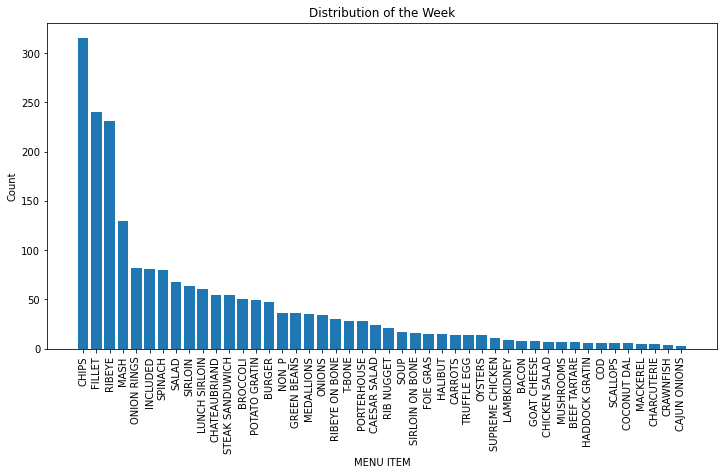

In [22]:

counts = dataset['MENU_ITEM'].value_counts()
# create a bar chart using the counts data
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(counts.index, counts.values)

# set the title and labels for the chart
ax.set_title('Distribution of the Week')
ax.set_xlabel('MENU ITEM')
ax.set_ylabel('Count')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# display the chart
plt.show()

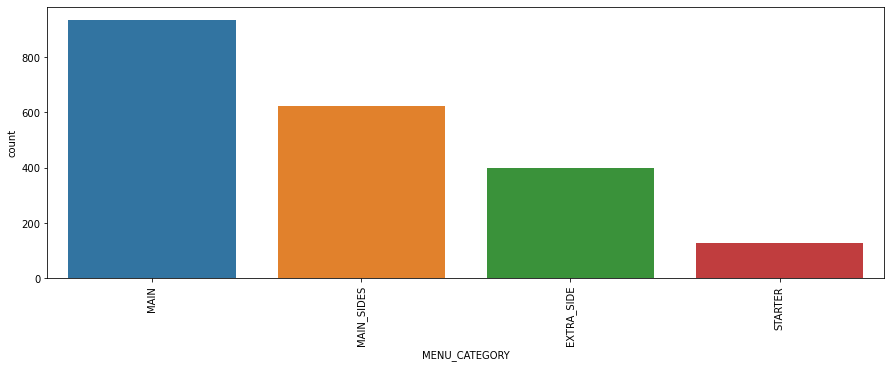

In [23]:

# Counting total of each 'MENU_CATEGORY'
counts = dataset['MENU_CATEGORY'].value_counts()
order = counts.index.tolist()
plt.figure(figsize=(15,5))
graph = sns.countplot('MENU_CATEGORY', data = dataset, order=order)
graph.tick_params(axis='x', rotation=90)

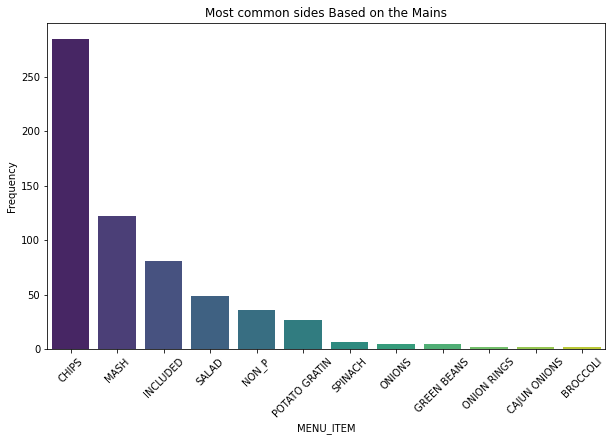

In [24]:

# Filter the dataset for MENU_CATEGORY equal to MAIN_SIDES
main_sides_data = dataset[dataset['MENU_CATEGORY'] == 'MAIN_SIDES']

# Count the frequency of each MENU_ITEM within MAIN_SIDES category
menu_item_counts = main_sides_data['MENU_ITEM'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=menu_item_counts.index, y=menu_item_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('MENU_ITEM')
plt.ylabel('Frequency')
plt.title('Most common sides Based on the Mains')
plt.show()

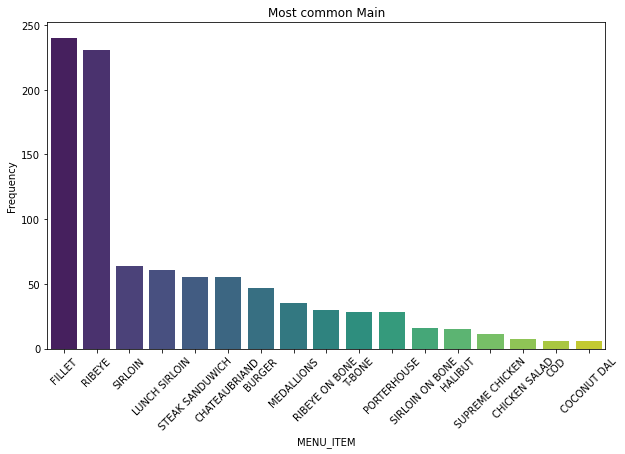

In [25]:

# Filter the dataset for MENU_CATEGORY equal to MAIN_SIDES
main_sides_data = dataset[dataset['MENU_CATEGORY'] == 'MAIN']

# Count the frequency of each MENU_ITEM within MAIN_SIDES category
menu_item_counts = main_sides_data['MENU_ITEM'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=menu_item_counts.index, y=menu_item_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('MENU_ITEM')
plt.ylabel('Frequency')
plt.title('Most common Main')
plt.show()

In [26]:
explo_dataset_saved = dataset

In [27]:
explo_dataset_saved.head(100)

,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,DAY_TYPE,QUANTITY
0,81243,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,WEEKDAY,1
1,81243,2023-03-03,LUNCH,INCLUDED,MAIN_SIDES,Not Applicable,Not Applicable,0.0,Friday,WEEKDAY,1
2,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,WEEKDAY,2
3,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,WEEKDAY,2
4,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,WEEKDAY,2
...,...,...,...,...,...,...,...,...,...,...,...
95,99297,2023-03-03,DINNER,GREEN BEANS,EXTRA_SIDE,Not Applicable,Not Applicable,6.0,Friday,WEEKDAY,1
96,99297,2023-03-03,DINNER,BROCCOLI,EXTRA_SIDE,Not Applicable,Not Applicable,7.0,Friday,WEEKDAY,1
97,99297,2023-03-03,DINNER,SPINACH,EXTRA_SIDE,Not Applicable,Not Applicable,6.0,Friday,WEEKDAY,1
98,99297,2023-03-03,DINNER,ONION RINGS,EXTRA_SIDE,Not Applicable,Not Applicable,7.0,Friday,WEEKDAY,1


In [28]:
dataset['DATE'] = pd.to_datetime(dataset['DATE'])

### Splting of dataset into Mains and Others, so we try to have a better result on forecasting Mains with less noisy. 

In [29]:
# Dividing data based on MAINS
main = dataset[dataset['MENU_CATEGORY']=='MAIN']
print(main.shape)
main.head()

(935, 11)


,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,DAY_TYPE,QUANTITY
0,81243,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,WEEKDAY,1
2,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,WEEKDAY,2
3,82246,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,WEEKDAY,2
4,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,WEEKDAY,2
5,82246,2023-03-03,LUNCH,RIBEYE,MAIN,M,PEPPER,47.0,Friday,WEEKDAY,2


In [30]:
#others = dataset[dataset['MENU_CATEGORY'].isin(['MAIN_SIDES', 'EXTRA_SIDES', 'STARTERS'])]
#print(others.shape)
#others.head()

<AxesSubplot:>

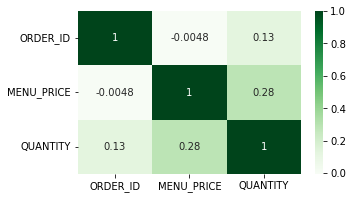

In [31]:
plt.figure(figsize=(5,3))
sns.heatmap(dataset.corr(),annot=True, cmap="Greens")

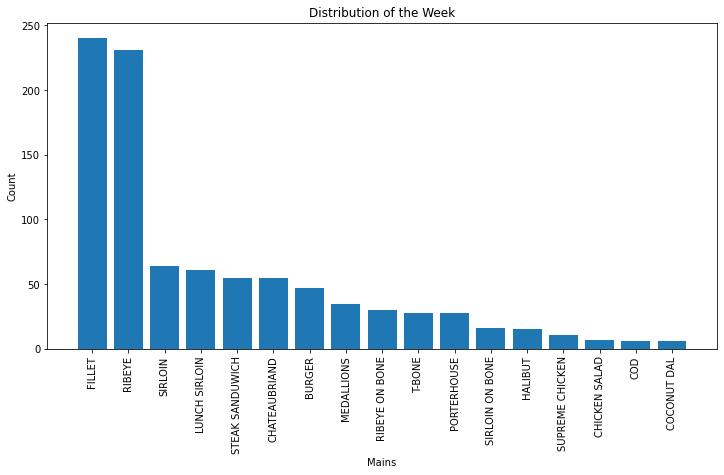

In [32]:
main_counts = main['MENU_ITEM'].value_counts()

# create a bar chart using the counts data
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(main_counts.index, main_counts.values)

# set the title and labels for the chart
ax.set_title('Distribution of the Week')
ax.set_xlabel('Mains')
ax.set_ylabel('Count')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# display the chart
plt.show()

In [33]:
#main.drop(['DATE','DAY_TYPE'], axis=1, inplace=True)

In [34]:
main.drop('ORDER_ID', axis=1, inplace=True)

In [35]:
main.head()

,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,DAY_TYPE,QUANTITY
0,2023-03-03,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,WEEKDAY,1
2,2023-03-03,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,WEEKDAY,2
3,2023-03-03,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,WEEKDAY,2
4,2023-03-03,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,WEEKDAY,2
5,2023-03-03,LUNCH,RIBEYE,MAIN,M,PEPPER,47.0,Friday,WEEKDAY,2


In [36]:
#others.drop(['TEMP','DAY_TYPE'], axis=1, inplace=True)

In [37]:
#others.drop('SAUCE', axis=1, inplace=True)

In [38]:
#others.drop('ORDER_ID', axis=1, inplace=True)

In [39]:
#others.head()

In [40]:
#main['MENU_ITEM'] = pd.Categorical(main['MENU_ITEM'])

In [41]:
main['DATE'] = main['DATE'].values.astype(float)

In [42]:
main.drop('DAY_TYPE', axis=1, inplace=True)

In [43]:
main.head()

,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,QUANTITY
0,1.677802e+18,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,1
2,1.677802e+18,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,2
3,1.677802e+18,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,2
4,1.677802e+18,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,2
5,1.677802e+18,LUNCH,RIBEYE,MAIN,M,PEPPER,47.0,Friday,2


### Applying label encoding to variables used to do the prediction 

In [44]:
main.dtypes

DATE             float64
TIME              object
MENU_ITEM         object
MENU_CATEGORY     object
TEMP              object
SAUCE             object
MENU_PRICE       float64
DAY_OF_WEEK       object
QUANTITY           int64
dtype: object

In [45]:


le = LabelEncoder()
main['MENU_CATEGORY'] = le.fit_transform(main['MENU_CATEGORY'])
main['DAY_OF_WEEK'] = le.fit_transform(main['DAY_OF_WEEK'])
main['TIME'] = le.fit_transform(main['TIME'])
main['SAUCE'] = le.fit_transform(main['SAUCE'])
main['TEMP'] = le.fit_transform(main['TEMP'])
main['MENU_ITEM'] = le.fit_transform(main['MENU_ITEM'])

In [46]:
main.head()

,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,QUANTITY
0,1.677802e+18,1,9,0,1,2,98.0,0,1
2,1.677802e+18,1,8,0,2,4,32.0,0,2
3,1.677802e+18,1,8,0,1,4,32.0,0,2
4,1.677802e+18,1,10,0,1,0,47.0,0,2
5,1.677802e+18,1,10,0,1,6,47.0,0,2


# knn on main splits

Finding the best numeber for n_neighbors: 

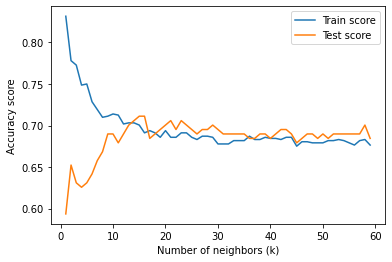

In [102]:


# Separate the independent and dependent variables
X = main.drop(['QUANTITY'], axis=1)
y = main['QUANTITY']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
k_values = range(1, 60)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))


plt.plot(k_values, train_scores, label='Train score')
plt.plot(k_values, test_scores, label='Test score')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

Here we can observe that a number Between 50 and 60 is the best match for the model 

In [48]:
# Separate the independent and dependent variables
X = main.drop(['QUANTITY'], axis=1)
y = main['QUANTITY']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the kNN model with the training set
k = 55  # choose the number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Evaluate the performance on the testing set
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6898395721925134
              precision    recall  f1-score   support

           1       0.70      0.97      0.81       128
           2       0.50      0.14      0.21        37
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        10

    accuracy                           0.69       187
   macro avg       0.30      0.28      0.26       187
weighted avg       0.58      0.69      0.60       187



### Applying Knn with StandardScaler

In [96]:



# Separate the independent and dependent variables
X = main.drop(['QUANTITY'], axis=1)
y = main['QUANTITY']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the kNN model with the training set
k =55  # choose the number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Evaluating the performance 
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))



Accuracy: 0.6737967914438503
              precision    recall  f1-score   support

           1       0.67      1.00      0.80       124
           2       1.00      0.04      0.09        45
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         9

    accuracy                           0.67       187
   macro avg       0.42      0.26      0.22       187
weighted avg       0.69      0.67      0.55       187



The KNN model appears to perform rather well for a few categories (Recall, and F1-scores)
Low accuracy on recall, and F1-scores suggest that the model performs poorly or is unable to correctly predict outcomes for additional classes, such as Chicken Salad, Coconut Dal, Cod.

KNN is not an appropriate algorithm for such an approach since it is a lazy learning algorithm that saves all of the training data and makes predictions based on the similarity of the new data point to the training data. The model may struggle to handle the high-dimensional and limited data contained in restaurant menus in this situation. Furthermore, KNN is susceptible to outliers and noisy data, which might affect the model's prediction accuracy.


# Random Forest classifier on Mains Splits 

In [97]:
main.head()

,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,QUANTITY
0,1.677802e+18,1,9,0,1,2,98.0,0,1
2,1.677802e+18,1,8,0,2,4,32.0,0,2
3,1.677802e+18,1,8,0,1,4,32.0,0,2
4,1.677802e+18,1,10,0,1,0,47.0,0,2
5,1.677802e+18,1,10,0,1,6,47.0,0,2


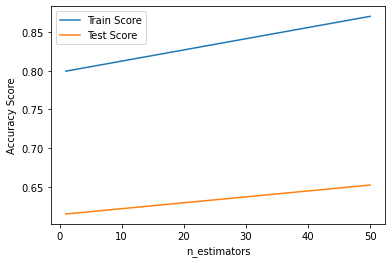

In [98]:
n_estimators_range = (1, 50)

# Initialize empty lists to store the training and testing scores
train_scores = []
test_scores = []

# Train and evaluate the model with different values of n_estimators
for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=100)
    rf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

# Plot the training and testing scores against n_estimators
plt.plot(n_estimators_range, train_scores, label='Train Score')
plt.plot(n_estimators_range, test_scores, label='Test Score')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()


## Random Forest + StandardScaler on Mains Splits

In [52]:



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the dataset using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=20, random_state=100)

# Train the Random Forest Classifier on the training set
rfc.fit(X_train_scaled, y_train)

# Make predictions using the Random Forest Classifier
y_pred = rfc.predict(X_test_scaled)

# Evaluate the performance of the Random Forest Classifier on the testing set
accuracy = rfc.score(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


Accuracy: 0.6042780748663101
              precision    recall  f1-score   support

           1       0.73      0.78      0.75       125
           2       0.39      0.30      0.34        43
           3       0.14      0.22      0.17         9
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         2

    accuracy                           0.60       187
   macro avg       0.25      0.26      0.25       187
weighted avg       0.58      0.60      0.59       187



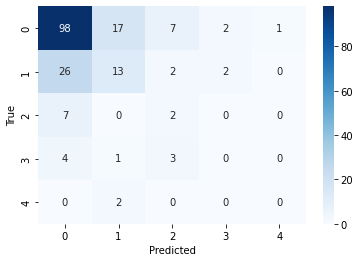

In [53]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The actual labels are shown in the rows, while the anticipated labels are represented in the columns. True positives are diagonal elements, while false positives and false negatives are off-diagonal elements.

# Decision Tree Classifier - whole dataset 

Train Accuracy:
Number of training samples: 70  |  Training Accuracy: 0.9697
Number of training samples: 228  |  Training Accuracy: 0.9260
Number of training samples: 387  |  Training Accuracy: 0.8903
Number of training samples: 545  |  Training Accuracy: 0.8732
Number of training samples: 704  |  Training Accuracy: 0.8739

Test Accuracy:
Number of training samples: 70  |  Validation Accuracy: 0.5628
Number of training samples: 228  |  Validation Accuracy: 0.6404
Number of training samples: 387  |  Validation Accuracy: 0.6324
Number of training samples: 545  |  Validation Accuracy: 0.6417
Number of training samples: 704  |  Validation Accuracy: 0.6671


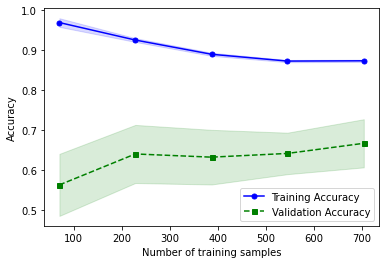

In [99]:

X = explo_dataset_saved.drop(['QUANTITY'], axis=1)
y = explo_dataset_saved['QUANTITY']

from sklearn.model_selection import train_test_split, learning_curve
# Instantiate a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=17, scoring='accuracy', n_jobs=-1)

# Calculate the mean and standard deviation for the training scores and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Print the accuracy of train and test
print("Train Accuracy:")
for size, score in zip(train_sizes, train_mean):
    print(f"Number of training samples: {size}  |  Training Accuracy: {score:.4f}")

print("\nTest Accuracy:")
for size, score in zip(train_sizes, test_mean):
    print(f"Number of training samples: {size}  |  Validation Accuracy: {score:.4f}")



# Plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [100]:



# Scale the dataset using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier on the training set
dtc.fit(X_train_scaled, y_train)

# Make predictions using the Decision Tree Classifier
y_pred = dtc.predict(X_test_scaled)

# Evaluate the performance of the Decision Tree Classifier on the testing set
accuracy = dtc.score(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6737967914438503
[[107  14   3   0   0]
 [ 27  16   1   0   1]
 [  6   1   1   1   0]
 [  3   0   4   2   0]
 [  0   0   0   0   0]]


In [56]:
#copydataset = dataset

In [57]:
#dataset = dataset.drop(['ORDER_ID','TEMP','SAUCE'], axis=1, inplace=True)

In [58]:
explo_dataset_saved['DATE'] = explo_dataset_saved['DATE'].values.astype(float)

In [59]:
explo_dataset_saved.head()

,ORDER_ID,DATE,TIME,MENU_ITEM,MENU_CATEGORY,TEMP,SAUCE,MENU_PRICE,DAY_OF_WEEK,DAY_TYPE,QUANTITY
0,81243,1.677802e+18,LUNCH,PORTERHOUSE,MAIN,M,INCLUDED,98.0,Friday,WEEKDAY,1
1,81243,1.677802e+18,LUNCH,INCLUDED,MAIN_SIDES,Not Applicable,Not Applicable,0.0,Friday,WEEKDAY,1
2,82246,1.677802e+18,LUNCH,MEDALLIONS,MAIN,MR,NON_P,32.0,Friday,WEEKDAY,2
3,82246,1.677802e+18,LUNCH,MEDALLIONS,MAIN,M,NON_P,32.0,Friday,WEEKDAY,2
4,82246,1.677802e+18,LUNCH,RIBEYE,MAIN,M,BEARNAISE,47.0,Friday,WEEKDAY,2


# Using the whole dataset to Train the model

# KNN

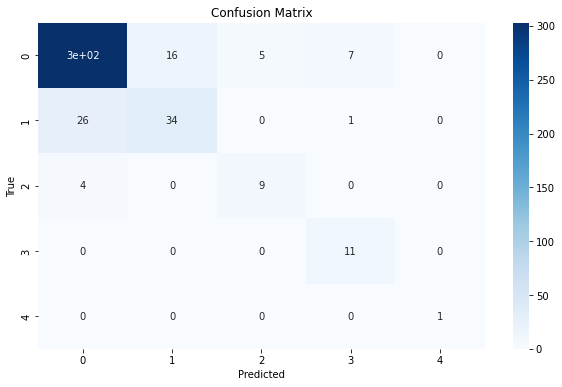

Accuracy: 0.8033573141486811
              precision    recall  f1-score   support

           1       0.84      0.95      0.89       331
           2       0.71      0.20      0.31        61
           3       0.00      0.00      0.00        13
           4       0.43      0.55      0.48        11
           5       0.50      1.00      0.67         1

    accuracy                           0.80       417
   macro avg       0.49      0.54      0.47       417
weighted avg       0.78      0.80      0.77       417



In [65]:
le = LabelEncoder()
explo_dataset_saved['MENU_CATEGORY'] = le.fit_transform(explo_dataset_saved['MENU_CATEGORY'])
explo_dataset_saved['DAY_OF_WEEK'] = le.fit_transform(explo_dataset_saved['DAY_OF_WEEK'])
explo_dataset_saved['SAUCE'] = le.fit_transform(explo_dataset_saved['SAUCE'])
explo_dataset_saved['TEMP'] = le.fit_transform(explo_dataset_saved['TEMP'])
explo_dataset_saved['MENU_ITEM'] = le.fit_transform(explo_dataset_saved['MENU_ITEM'])
explo_dataset_saved['TIME'] = le.fit_transform(explo_dataset_saved['TIME'])

#Split the dataset into training and testing sets:

X = explo_dataset_saved.drop(['QUANTITY','DAY_TYPE','TEMP'], axis=1)  # independent variables
y = explo_dataset_saved['QUANTITY']  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
#Train the kNN model with the training set:

k = 5  # choose the number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
#Evaluate the performance of the model with the testing set:
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the figure size
plt.figure(figsize=(10,6))

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

# Add labels, title and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


plt.show()



accuracy = knn.score(X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

# Random Forest Regressor

In [68]:


# Train the random forest model with the training set
n_estimators = 9  # choose the number of trees in the forest
rf = RandomForestRegressor(n_estimators=n_estimators)
rf.fit(X_train, y_train)

# Evaluate the performance of the model with the testing set
rf_score = rf.score(X_test, y_test)
print(f'R^2 Score: {rf_score}')

# Make predictions on the testing set
rf_predictions = rf.predict(X_test)


# Evaluate the predictions
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
print(f"RMSE: {rf_rmse}")

R^2 Score: 0.5304656350202147
RMSE: 0.46390259030010605


# DecisionTreeClassifier

In [94]:
# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Fit the model to the training data
dtc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = dtc.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Calculate the R² score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')




Accuracy: 0.0
RMSE: 22.638462845343543
R² Score: -1.1331945889698232


# Decision Tree Regressor

In [106]:
# Create an instance of the DecisionTreeRegressor
dtr = DecisionTreeRegressor()

# Fit the model to the training data
dtr.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = dtr.predict(X_test)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Calculate the R² score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

RMSE: 0.9425374773519781
R² Score: -0.27089067598075056


# Time series 

In [ ]:
dataset.head()

## RandomForestRegressor

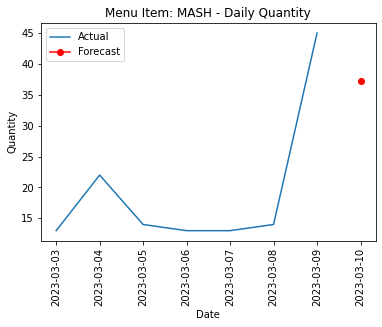

Last Data Point: 45
Forecast for 2023-03-10: [37.22]
RMSE: 3.537523346717507


In [79]:
import pandas as pd

from sklearn.model_selection import train_test_split


#Read the dataset into a DataFrame
data = pd.read_csv("explo_dataset_saved.csv")

le = LabelEncoder()
data['DAY_OF_WEEK'] = le.fit_transform(data['DAY_OF_WEEK'])
data['MENU_CATEGORY'] = le.fit_transform(data['MENU_CATEGORY'])

# Convert the "DATE" column to datetime type
data["DATE"] = pd.to_datetime(data["DATE"])

# Aggregate the data by date and sum the quantities for each menu item
daily_data = data.groupby(["DATE", "MENU_ITEM"])["QUANTITY"].sum().reset_index()

# Select the specific menu item for analysis
menu_item = "MASH"
menu_data = daily_data[daily_data["MENU_ITEM"] == menu_item]

# Sort the data by date
menu_data = menu_data.sort_values("DATE")

# Calculate the moving average
menu_data["MA"] = menu_data["QUANTITY"].rolling(window=7).mean()

# Prepare the data for Random Forests
X = menu_data["DATE"].apply(lambda x: x.toordinal()).values.reshape(-1, 1)
y = menu_data["QUANTITY"].values

# Train the Random Forest model
n_estimators = 100  # choose the number of trees in the forest
rf = RandomForestRegressor(n_estimators=n_estimators)
rf.fit(X, y)

# Plot the actual data and the moving average
plt.plot(menu_data["DATE"], menu_data["QUANTITY"], label="Actual")


# Get the most recent data point for forecasting
last_date = menu_data.iloc[-1]["DATE"]
last_data_point = menu_data.iloc[-1]["QUANTITY"]

# Forecast the next day's quantity using RandomForestRegressor
next_date = last_date + pd.DateOffset(days=1)
next_date_ordinal = next_date.toordinal()  # Convert to ordinal value
forecast = rf.predict([[next_date_ordinal]])

# Plot the forecasted value
plt.plot(forecast_date, forecast, marker="o", color="red", label="Forecast")

plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title(f"Menu Item: {menu_item} - Daily Quantity")
plt.xticks(rotation=90)
plt.legend()
plt.show()

print(f"Last Data Point: {last_data_point}")
print(f"Forecast for {forecast_date.date()}: {forecast}")


# Calculate RMSE
actual_values = menu_data["QUANTITY"].values[-7:]
forecast_values = rf.predict(X[-7:])
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print(f"RMSE: {rmse}")

## Predicting Using Moving Average 

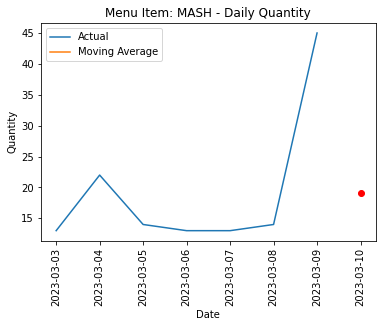

Last Data Point: 45
Forecast for 2023-03-10: 19.142857142857142


In [89]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Read the dataset into a DataFrame
data = pd.read_csv("explo_dataset_saved.csv")

# Convert the "DATE" column to datetime type
data["DATE"] = pd.to_datetime(data["DATE"])

# Aggregate the data by date and sum the quantities for each menu item
daily_data = data.groupby(["DATE", "MENU_ITEM"])["QUANTITY"].sum().reset_index()

# Select the specific menu item for analysis
menu_item = "MASH"
menu_data = daily_data[daily_data["MENU_ITEM"] == menu_item]

# Sort the data by date
menu_data = menu_data.sort_values("DATE")

# Calculate the moving average
menu_data["MA"] = menu_data["QUANTITY"].rolling(window=7).mean()

# Plot the actual data and the moving average
plt.plot(menu_data["DATE"], menu_data["QUANTITY"], label="Actual")
plt.plot(menu_data["DATE"], menu_data["MA"], label="Moving Average")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title(f"Menu Item: {menu_item} - Daily Quantity")
plt.legend()

# Get the most recent data point for forecasting
last_date = menu_data.iloc[-1]["DATE"]
last_data_point = menu_data.iloc[-1]["QUANTITY"]

# Forecast the next day's quantity using the moving average
forecast_date = last_date + timedelta(days=1)
forecast = menu_data["MA"].iloc[-1]

# Plot the forecasted value
plt.plot(forecast_date, forecast, marker="o", color="red", label="Forecast")
plt.xticks(rotation=90)

plt.show()

print(f"Last Data Point: {last_data_point}")
print(f"Forecast for {forecast_date.date()}: {forecast}")

## ARIMA Model

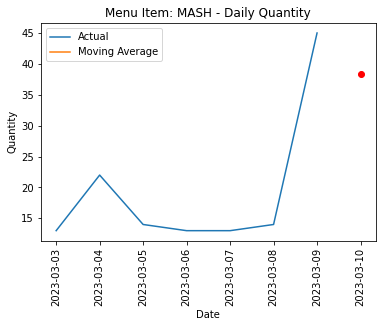

Last Data Point: 45
Forecast for 2023-03-10: 38.3640306691016
RMSE: 19.3937034751342


In [63]:

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Read the dataset into a DataFrame
data = pd.read_csv("explo_dataset_saved.csv")

# Convert the "DATE" column to datetime type
data["DATE"] = pd.to_datetime(data["DATE"])

# Aggregate the data by date and sum the quantities for each menu item
daily_data = data.groupby(["DATE", "MENU_ITEM"])["QUANTITY"].sum().reset_index()

# Select the specific menu item for analysis
menu_item = "MASH"
menu_data = daily_data[daily_data["MENU_ITEM"] == menu_item]

# Sort the data by date
menu_data = menu_data.sort_values("DATE")

# Calculate the moving average
menu_data["MA"] = menu_data["QUANTITY"].rolling(window=7).mean()

# Plot the actual data and the moving average
plt.plot(menu_data["DATE"], menu_data["QUANTITY"], label="Actual")
plt.plot(menu_data["DATE"], menu_data["MA"], label="Moving Average")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title(f"Menu Item: {menu_item} - Daily Quantity")
plt.legend()

# Get the most recent data point for forecasting
last_date = menu_data.iloc[-1]["DATE"]
last_data_point = menu_data.iloc[-1]["QUANTITY"]


# Convert the quantity column to a Series with the date as index
series = pd.Series(menu_data["QUANTITY"].values, index=menu_data["DATE"])

# Fit the ARIMA model
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next day's quantity using ARIMA
forecast_date = last_date + timedelta(days=1)
forecast = model_fit.forecast(steps=1)[0]

# Plot the forecasted value
plt.plot(forecast_date, forecast, marker="o", color="red", label="Forecast")
plt.xticks(rotation=90)

plt.show()

print(f"Last Data Point: {last_data_point}")
print(f"Forecast for {forecast_date.date()}: {forecast}")


# Calculate RMSE
actual_values = menu_data["QUANTITY"].values[-7:]
forecast_values = model_fit.predict(start=len(menu_data), end=len(menu_data) + 6)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print(f"RMSE: {rmse}")

# Decision Tree Regression model

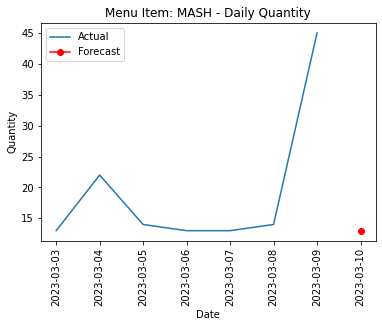

Last Data Point: 45
Forecast for 2023-03-10: [13.]
RMSE: 22.638462845343543


In [93]:

data = pd.read_csv("explo_dataset_saved.csv")

le = LabelEncoder()
data['DAY_OF_WEEK'] = le.fit_transform(data['DAY_OF_WEEK'])
data['MENU_CATEGORY'] = le.fit_transform(data['MENU_CATEGORY'])

# Convert the "DATE" column to datetime type
data["DATE"] = pd.to_datetime(data["DATE"])

# Aggregate the data by date and sum the quantities for each menu item
daily_data = data.groupby(["DATE", "MENU_ITEM"])["QUANTITY"].sum().reset_index()

# Select the specific menu item for analysis
menu_item = "MASH"
menu_data = daily_data[daily_data["MENU_ITEM"] == menu_item]

# Sort the data by date
menu_data = menu_data.sort_values("DATE")

# Calculate the moving average
menu_data["MA"] = menu_data["QUANTITY"].rolling(window=7).mean()

# Prepare the data for Decision Tree Regression
X = menu_data["DATE"].apply(lambda x: x.toordinal()).values.reshape(-1, 1)
y = menu_data["QUANTITY"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Decision Tree model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Plot the actual data
plt.plot(menu_data["DATE"], menu_data["QUANTITY"], label="Actual")

# Get the next date after the last data point
next_date = menu_data["DATE"].max() + pd.DateOffset(days=1)
next_date_ordinal = next_date.toordinal()  # Convert to ordinal value

# Forecast the next day's quantity using DecisionTreeRegressor
forecast = dt.predict([[next_date_ordinal]])

# Plot the forecasted value
plt.plot(next_date, forecast, marker="o", color="red", label="Forecast")

plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title(f"Menu Item: {menu_item} - Daily Quantity")
plt.xticks(rotation=90)
plt.legend()
plt.show()

print(f"Last Data Point: {menu_data['QUANTITY'].iloc[-1]}")
print(f"Forecast for {next_date.date()}: {forecast}")

# Calculate RMSE on the testing set
y_test_pred = dt.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE: {rmse}")